Connected to integrating (Python 3.11.5)

In [1]:
from PointList import *
%matplotlib widget 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
c = PointList()
c.add_point((2,3,0))
c.add_point((1,7,2))
c.add_point((5,9,0))
c.add_point((10,8,5))
c.add_point((11,4,-2))



In [784]:
from PointList import *
from Triangle import *
from tqdm import tqdm
from copy import *


class TriangularMesh:
    def __init__(self, boundary : PointList, desired_triangle_count):
        self.boundary = boundary 
        self.m = desired_triangle_count
        self.mesh = []
        self.n = len(boundary.points)
        self.v_indexes = [] #the vertexes indices
        self.mapping = [] #contains the mapping from I(v_indexes) to R^3
        self.triangles  = []  #each triangle is a tuple
        self.inside_indexes  = []
        self.N = {} #les indices des voisins 
        self.N_vertexes = len(self.v_indexes) # the number of nodes in the meshing
        self.w = np.empty((len(self.v_indexes),len(self.v_indexes)))
        self.dict_vertexes = {} # contains the dict of all triangles associated to an index
        self.edges = set()
        self.vertex_curvatures = dict()
    

    def add_points_to_boundary(self,N = 10):
        "adding points to the boundary"
        K = deepcopy(self.boundary.points)
        R = []
        for i in tqdm(range(len(self.boundary.points))):
            
            p1 = K[i-1]
            p2 = K[i]
            L = list(np.linspace(p1,p2,N+2))[1:-1]

            R.append(p1)
            R = R + L
        self.boundary.points = R
        self.n = len(self.boundary.points)



    def compute_central_point(self):
        return self.boundary.average_point()
        
         
    def create_initial_subdivisions(self):
        #  Create initial subdivisions using the central point
        C = self.compute_central_point()
        s = int(self.m/(2*self.n) - 1/2)
        triangle = self.boundary.points + [self.boundary.points[0]]
        P = [triangle]
        for j in range(1,s+1):
            P_j = triangle + (j / (s+1))*(C - triangle)
            P.append(P_j)
        
        return np.array(P)
        

    def create_quadrilaterals(self):
        #split the outside quadrilaterals
        P = self.create_initial_subdivisions()
        s = int(self.m/(2*self.n) - 1/2)
        for j in tqdm(range(s)) : 
            for i in range(self.n) :
                self.mesh.append([P[j,i],P[j+1,i+1],P[j,i+1]])
                self.mesh.append([P[j,i],P[j+1,i+1],P[j+1,i]])
        
        


    def split_quadrilateral(self):
        C = self.compute_central_point()
        P = self.create_initial_subdivisions()
        for i in tqdm(range(self.n)) :
            self.mesh.append([C,P[-1,i],P[-1,i+1]])

    def further_subdivide(self):
        while len(self.mesh) < self.m :
            k = np.random.randint(0,len(self.mesh))
            tri = np.array(self.mesh.pop(k))
            C = np.mean(tri,axis = 0)
            tri1 = [tri[0],tri[1],C]
            tri2 = [tri[0],tri[2],C]
            tri3 = [tri[1],tri[2],C]
            self.mesh += [tri1,tri2,tri3]
    



    def generate_mesh_initial(self):
        self.create_quadrilaterals()
        # self.further_subdivide()
        return self.mesh


    def modify_N(self,i):
        N = []
        for tr in self.triangles :
            if i in tr:
                N += list(tr)
        self.N[i] = list(set(N))
        self.N[i].remove(i)


    def canonic_representation_from_mesh(self):
        K = np.array(self.mesh).reshape(-1,3)
        K = [tuple(x) for x in K]
        N = len(set(K))
        self.N_vertexes = N
        self.w = np.empty((N,N))
        self.v_indexes = list(range(N))
        self.mapping = list(set(K))
        for j in self.v_indexes:
            self.dict_vertexes[j] = []
        self.triangles = []
        for tri in self.mesh:
            triangle = [self.mapping.index(tuple(pt)) for pt in tri]
            self.triangles.append(triangle)
            self.dict_vertexes[triangle[0]].append(tuple(triangle))
            self.dict_vertexes[triangle[1]].append(tuple(triangle))
            self.dict_vertexes[triangle[2]].append(tuple(triangle))

        for i in self.v_indexes:
            self.modify_N(i)

        Outside = [tuple(k) for k in self.boundary.points]
        Outside_vertexes = [self.mapping.index((pt)) for pt in Outside]
        self.inside_indexes = list(set(self.v_indexes) - set(Outside_vertexes))

    
    def tuple_mapping(self):
        self.mapping = [tuple(k) for k in self.mapping]

            


    def area_3D(self,tr):
        v = [self.mapping[tr[0]],self.mapping[tr[1]],self.mapping[tr[2]]]
        return area_3D(v)


    def _N(self,i):
        N = []
        for tr in self.triangles :
            if i in tr:
                N += list(tr)
        return list(set(N))



    def S(self,i,j):
        S = 0
        tr_i = set(self.dict_vertexes[i])
        tr_j = set(self.dict_vertexes[j])
        intersect = list(tr_i.intersection(tr_j))
        for tr in intersect :
            S+= self.area_3D(tr)
        return S


    def calcul_weights(self,i,j) :
        S = 0
        for k in self.N[i]:
            S += self.S(i,k)
        self.w[i,j] =  self.S(i,j)/S




    def cotangent_angle(self, p1, p2, p3):
        """Compute the cotangent of the angle between p1-p2 and p1-p3."""
        v1 = np.array(self.mapping[p2]) - np.array(self.mapping[p1])
        v2 = np.array(self.mapping[p3]) - np.array(self.mapping[p1])
        dot_product = np.dot(v1, v2)
        cross_product_norm = np.linalg.norm(np.cross(v1, v2))
        return dot_product / cross_product_norm

    def adjacent_area(self, vertex):
        """Compute the total area of triangles adjacent to the vertex."""
        area = 0
    
        triangles = self.dict_vertexes[vertex]
        for tri in triangles:
            area += self.area_3D(tri)
    
        return area


    def compute_mean_curvature(self):
        """Compute the mean curvature for each vertex in the mesh."""
        self.vertex_curvatures = dict()
        for i in self.inside_indexes:
            A_i = self.adjacent_area(i)
            curvature_sum = np.zeros(3)
            
            for j in self.N[i]:
                
                tr_i = set(self.dict_vertexes[i])
                tr_j = set(self.dict_vertexes[j])

                t1= list(tr_i.intersection(tr_j))[0]
                t2= list(tr_i.intersection(tr_j))[1]
                

                alpha = [r for r in t1 if r not in (i,j)][0]
                beta = [r for r in t2 if r not in (i,j)][0]

                cot_alpha = self.cotangent_angle(alpha,i,j)
                cot_beta = self.cotangent_angle(beta,j,i)

                p_i = np.array(self.mapping[i]) 
                p_j = np.array(self.mapping[j]) 

                curvature_sum += (cot_alpha + cot_beta) *(p_j - p_i)

            
            h_i = np.linalg.norm(curvature_sum) / (4 * A_i)
            self.vertex_curvatures[h_i] = i
        A = np.array(list(self.vertex_curvatures.keys()))
        
        return np.max(A)



In [500]:
R = []
S2 = []
S1 = []
S3 = []
S4 = []
U = np.linspace(-3*np.pi/5,3*np.pi/5,2)
V = np.linspace(-2,2,20)
polygone = PointList()
for u in [-3*np.pi/5]  :
    for v in V :
        S2.append((np.cosh(v)*np.cos(u),np.cosh(v)*np.sin(u),v))
S2.reverse()
for u in [3*np.pi/5]  :
    for v in V :
        S3.append((np.cosh(v)*np.cos(u),np.cosh(v)*np.sin(u),v))


U = np.linspace(-3*np.pi/5,3*np.pi/5,20)
V = np.linspace(-2,2,2)

for u in U :
    for v in [-2] :
        S1.append((np.cosh(v)*np.cos(u),np.cosh(v)*np.sin(u),v))

for u in U :
    for v in [2] :
        S4.append((np.cosh(v)*np.cos(u),np.cosh(v)*np.sin(u),v))

S4.reverse()



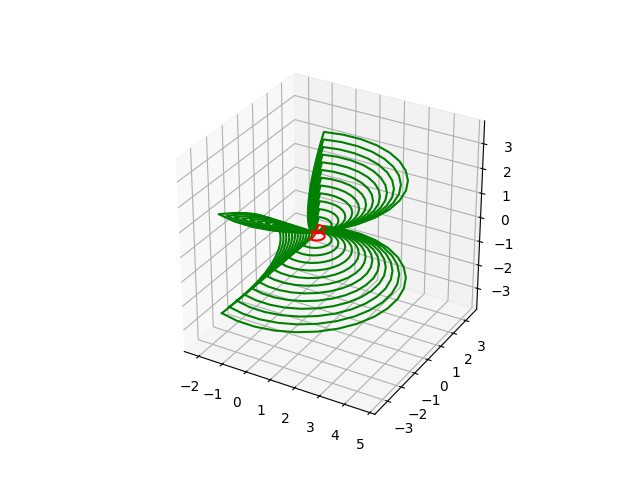

In [780]:

X = []
Y = []
Z = []
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(len(P)):
    L = P[i]
    L = np.array(L)
    xs = L[:,0]
    ys = L[:,1]
    zs = L[:,2]

    if i == len(P) - 1:
        plt.plot(xs,ys,zs,color='r')
    else :
        plt.plot(xs,ys,zs,color='green')
    
    X = X + list(xs)
    Y = Y + list(ys)
    Z = Z + list(zs)


X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)

max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0 

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)


polygone.points = S


ValueError: zero-size array to reduction operation maximum which has no identity

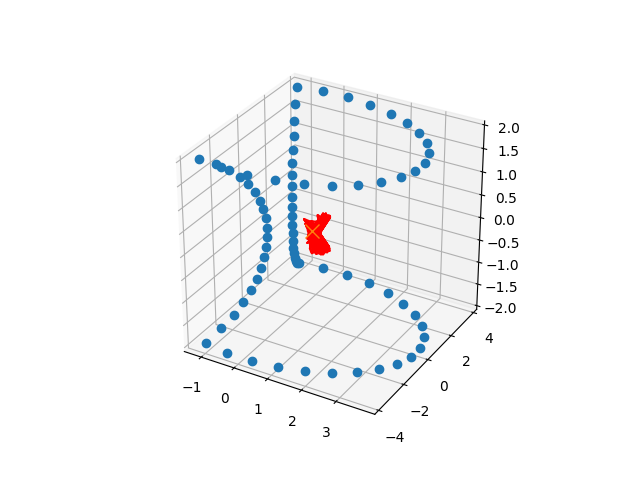

In [809]:
#Drawing the surfaces 

import PIL


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
X = []
Y = []
Z = []
# for tr in M.triangles:
#     # xs = [M.mapping[ind][0] for ind in tr] + [M.mapping[tr[0]][0]]
#     # ys = [M.mapping[ind][1] for ind in tr] + [M.mapping[tr[0]][1]]
#     # zs = [M.mapping[ind][2] for ind in tr] + [M.mapping[tr[0]][2]]
#     # ax.plot(xs,ys,zs,color='green')
#     # Z = Z + zs
#     # X = X + xs
#     # Y = Y + ys


L = polygone.points
L = np.array(L)
x = L[:,0]
y = L[:,1]
z = L[:,2]



plt.plot(x,y,z,"o")
X = []
Y = []
Z = []

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# for i in range(len(PIL)):
#     L = P[i]
#     L = np.array(L)
#     xs = L[:,0]
#     ys = L[:,1]
#     zs = L[:,2]

#     ax.plot(xs,ys,zs,color='green')
    
#     X = X + list(xs)
#     Y = Y + list(ys)
#     Z = Z + list(zs)


X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)


for tr in boundary_triangles:
    
    xs = [M.mapping[ind][0] for ind in tr] + [M.mapping[tr[0]][0]]
    ys = [M.mapping[ind][1] for ind in tr] + [M.mapping[tr[0]][1]]
    zs = [M.mapping[ind][2] for ind in tr] + [M.mapping[tr[0]][2]]

    ax.plot(xs,ys,zs,color = 'r')

C = M.compute_central_point()
plt.plot(C[0],C[1],C[2],"x", markersize = 10)

max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0 

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)



In [785]:
#class of updating_Laplace 
def distance(point1, point2):
    """Compute the Euclidean distance between two points."""
    return np.linalg.norm(np.array(point1) - np.array(point2))

def perimeter_3D(vertices):
    """Compute the perimeter of a triangle given its vertices."""
    return distance(vertices[0], vertices[1]) + distance(vertices[1], vertices[2]) + distance(vertices[0], vertices[2])


class Updating_Laplace(TriangularMesh):
    def __init__(self, boundary : PointList, desired_triangle_count):
        super().__init__(boundary, desired_triangle_count)

    def update_weights(self):
        "Updates the weights of the Mesh for each iteration"
        for i in (range(self.N_vertexes)):
            for j in (range(self.N_vertexes)):
                if i in self.N[j] :
                    self.calcul_weights(i,j)

    def calculate_area(self):
        "Calculates the area of the meshing"
        S = 0
        for tri in self.triangles:
            S = S + self.area_3D(tri)
        return S

    def update_mapping(self,i):
        "Updates the position of the nodes using the Laplace Fairing"
        N_i = self.N[i]
        P = np.array([0,0,0])
        for k in N_i :
            P = P + self.w[i,k]*np.array(self.mapping[k])
    
        self.mapping[i] = P



import numpy as np

def cotangent(p1, p2, p3):
    """Compute the cotangent of the angle between p1-p2 and p1-p3."""
    v1 = np.array(p2) - np.array(p1)
    v2 = np.array(p3) - np.array(p1)
    dot_product = np.dot(v1, v2)
    cross_product_norm = np.linalg.norm(np.cross(v1, v2))
    return dot_product / cross_product_norm

def triangle_area(p1, p2, p3):
    """Compute the area of a triangle defined by points p1, p2, p3."""
    v1 = np.array(p2) - np.array(p1)
    v2 = np.array(p3) - np.array(p1)
    return 0.5 * np.linalg.norm(np.cross(v1, v2))

def mean_curvature(mesh):
    """Compute the mean curvature for each vertex in the mesh."""
    vertex_curvatures = []
    for vertex in mesh:
        A_vertex = 0
        mean_curvature_normal = np.zeros(3)
        for triangle in mesh:
            if vertex in triangle:
                A_vertex += triangle_area(*triangle) / 3
                for i in range(3):
                    if triangle[i] == vertex:
                        cot_angle = cotangent(triangle[i], triangle[(i+1)%3], triangle[(i+2)%3])
                        edge_vector = np.array(triangle[(i+1)%3]) - np.array(triangle[i])
                        mean_curvature_normal += cot_angle * edge_vector
        H_vertex = np.linalg.norm(mean_curvature_normal) / (2 * A_vertex)
        vertex_curvatures.append(H_vertex)
    return vertex_curvatures



class Edge_Flipping(Updating_Laplace):
    def __init__(self, boundary : PointList, desired_triangle_count):
        super().__init__(boundary, desired_triangle_count)

    def fill_edges(self):
        for tri in self.triangles:
            for i in range(3):
                edge = tuple(sorted([tri[i], tri[(i+1)%3]]))
                self.edges.add(edge)

    def test(self,edge,tri):
        return set(edge).issubset(set(tri))
    
    def can_flip(self,edge):
        triangles = [triangle for triangle in self.triangles if self.test(edge,triangle)]
        return len(triangles) == 2
    
    def flip_edge(self,edge):
        triangles = [triangle for triangle in self.triangles if self.test(edge,triangle)]
        t1,t2 = triangles
        opposite_vertices = [v for v in t1 if v not in edge] + [v for v in t2 if v not in edge]
        new_triangles = [[edge[0], opposite_vertices[0], opposite_vertices[1]], 
                     [edge[1], opposite_vertices[0], opposite_vertices[1]]]
        for triangle in triangles:
            self.triangles.remove(triangle)
        self.triangles.extend(new_triangles)
        return triangles,new_triangles
    
    def lawson_flip(self):
       
        for edge in self.edges:
            if self.can_flip(edge):
                triangles = [triangle for triangle in self.triangles if self.test(edge,triangle)]
                old_area = sum(self.area_3D(triangle) for triangle in triangles)
                old_tr, new_tr = self.flip_edge(edge)
                new_area = sum(self.area_3D(triangle) for triangle in triangles)

                if new_area >=  old_area: 
                    for triangle in new_tr:
                        self.triangles.remove(triangle)
                    self.triangles.extend(old_tr) # Flip back if the new area is not smaller



# Placeholder mesh representation for testing

# Compute mean curvatures for the example mesh
# curvatures = mean_curvature(example_mesh)

# Due to the current environment limitations, direct execution is commented out.
# You can use the provided functions in your local environment to compute the mean curvature.

        

In [786]:
class Edge_Flipping(Updating_Laplace):
    def __init__(self, boundary : PointList, desired_triangle_count):
        super().__init__(boundary, desired_triangle_count)

    def fill_edges(self):
        self.edges = set()
        for tri in self.triangles:
            for i in range(3):
                edge = tuple(sorted([tri[i], tri[(i+1)%3]]))
                self.edges.add(edge)

    def test(self,edge,tri):
        return set(edge).issubset(set(tri))
    
    def can_flip(self,edge):
        triangles = [triangle for triangle in self.triangles if self.test(edge,triangle)]
        return len(triangles) == 2
    
    def flip_edge(self,edge):
        triangles = [triangle for triangle in self.triangles if self.test(edge,triangle)]
        t1,t2 = triangles
        opposite_vertices = [v for v in t1 if v not in edge] + [v for v in t2 if v not in edge]
        new_triangles = [[edge[0], opposite_vertices[0], opposite_vertices[1]], 
                     [edge[1], opposite_vertices[0], opposite_vertices[1]]]
        for triangle in triangles:
            self.triangles.remove(triangle)
        self.triangles.extend(new_triangles)
        return triangles,new_triangles
    
    def lawson_flip(self):
        L = {}
        for edge in self.edges:
            
            if self.can_flip(edge):
                triangles = [triangle for triangle in self.triangles if self.test(edge,triangle)]
                old_area = sum(self.area_3D(triangle) for triangle in triangles)
                old_tr, new_tr = self.flip_edge(edge)
                new_area = sum(self.area_3D(triangle) for triangle in triangles)
                L[edge] = (- new_area + old_area)
                if new_area >=  old_area: 
                    
                    for triangle in new_tr:
                        self.triangles.remove(triangle)
                    self.triangles.extend(old_tr)# Flip back if the new area is not smaller
        return L


In [802]:
from copy import *

polygone = PointList()
for k in S:
    polygone.add_point(k)

M = Edge_Flipping(polygone,2040)
# M.add_points_to_boundary(N = 5)
M.create_quadrilaterals()
M.split_quadrilateral()
M.further_subdivide()
M.canonic_representation_from_mesh()
# J.fill_edges()

Outside = [tuple(k) for k in M.boundary.points]
Outside_vertexes = [M.mapping.index((pt)) for pt in Outside]
Inside_vertexes = list(set(M.v_indexes) - set(Outside_vertexes))

centre = M.compute_central_point()
centre = tuple(centre)
ind = M.mapping.index(centre)
triangle_centre = M.dict_vertexes[ind]

# # Fliaring Laplace 
epsilon = 0.001
area = M.calculate_area()
M.update_weights()
for i in Inside_vertexes:
    M.update_mapping(i)


new_area = M.calculate_area()
while area - new_area >= epsilon:
    print("Step 2")
    area = M.calculate_area()
    M.update_weights()
    for i in Inside_vertexes:
        M.update_mapping(i)
    
    new_area = M.calculate_area()
    
    print(new_area,area - new_area,M.compute_mean_curvature(),M.vertex_curvatures[M.compute_mean_curvature()])


# # # M.canonic_representation()



100%|██████████| 76/76 [00:00<00:00, 76041.77it/s]


Step 2
61.34858406773417 0.4944216995401334 27.30197407244418 86
Step 2
61.05948612912609 0.2890979386080801 36.090036762720985 86
Step 2
60.85569907413093 0.2037870549951606 26.022534751501777 86
Step 2
60.669894138479016 0.18580493565191603 41.05078060616104 86
Step 2
60.53289878560381 0.13699535287520348 22.081250291138627 86
Step 2
60.418923000731205 0.11397578487260773 47.26727763187704 86
Step 2
60.32668695178362 0.09223604894758353 12.939841698819416 344
Step 2
60.24572687087979 0.08096008090382867 40.34846402895163 86
Step 2
60.182382065908136 0.06334480497165629 13.741770764037282 16
Step 2
60.14095931297571 0.041422752932426476 34.06773986944782 86
Step 2
60.0978474423474 0.04311187062830868 14.725346269063236 16
Step 2
60.08401601408146 0.013831428265937973 28.618737768612647 86
Step 2
60.04996290336981 0.03405311071165329 18.740084191997944 536
Step 2
60.036362276681 0.013600626688813122 24.713734021336684 86
Step 2
60.030213197824004 0.0061490788569926735 20.82742516440131

In [807]:
boundary_triangles = []
# M.tuple_mapping()
# P = M.create_initial_subdivisions()
# s = int(M.m/(2*M.n) - 1/2)
for bdry in [86]:
    boundary_triangles = boundary_triangles + M.dict_vertexes[ind]

L  = np.array(list(M.vertex_curvatures.keys()))


In [810]:
len(boundary_triangles)

77

In [721]:

for bdry in P[4][1:45]:
    ind = M.mapping.index(tuple(bdry))
    print(ind,M.N[ind])


60 [646, 46, 51, 408, 569, 30]
30 [646, 296, 977, 408, 155, 60]
155 [296, 977, 529, 467, 413, 30]
413 [529, 914, 595, 467, 209, 155]
595 [328, 104, 209, 914, 630, 413]
104 [644, 328, 595, 630, 314, 797]
644 [104, 841, 843, 440, 314, 797]
440 [644, 841, 843, 404, 919, 56]
404 [67, 581, 440, 919, 503, 56]
67 [260, 581, 271, 404, 182, 503]
271 [67, 964, 260, 170, 182, 87]
964 [449, 579, 201, 170, 271, 87]
579 [449, 964, 518, 201, 118, 862]
862 [579, 739, 869, 518, 594, 118]
739 [869, 359, 910, 594, 954, 862]
954 [739, 359, 268, 301, 814, 910]
301 [491, 268, 814, 339, 597, 954]
339 [674, 491, 301, 597, 345, 925]
674 [345, 339, 470, 502, 57, 925]
57 [674, 804, 72, 392, 470, 502]
392 [804, 72, 232, 976, 57, 154]
976 [292, 934, 392, 232, 154, 187]
187 [292, 934, 976, 720, 950, 729]
729 [129, 5, 904, 720, 950, 187]
5 [129, 324, 904, 208, 756, 729]
324 [673, 610, 5, 263, 208, 756]
610 [673, 324, 263, 105, 85, 88]
88 [577, 610, 105, 888, 85, 892]
577 [622, 591, 888, 88, 892, 734]
591 [577, 205, 

In [648]:
M.fill_edges()
for _ in range(10):
    area = M.calculate_area()
    L = M.lawson_flip()
    new_area = M.calculate_area()
    print(new_area -area,M.compute_mean_curvature())

# M.fill_edges()
# edge = list(M.edges)[0]
# M.can_flip(edge)


array([[-1.1625824 , -3.57806073, -2.        ],
       [-0.4344758 , -3.73702384, -2.        ],
       [ 0.31067966, -3.74934589, -2.        ],
       [ 1.04364403, -3.61454334, -2.        ],
       [ 1.73565574, -3.33790587, -2.        ],
       [ 2.35956019, -2.93028874, -2.        ],
       [ 2.89087535, -2.40768689, -2.        ],
       [ 3.30875236, -1.79060723, -2.        ],
       [ 3.5967937 , -1.10326403, -2.        ],
       [ 3.74369661, -0.37262867, -2.        ],
       [ 3.74369661,  0.37262867, -2.        ],
       [ 3.5967937 ,  1.10326403, -2.        ],
       [ 3.30875236,  1.79060723, -2.        ],
       [ 2.89087535,  2.40768689, -2.        ],
       [ 2.35956019,  2.93028874, -2.        ],
       [ 1.73565574,  3.33790587, -2.        ],
       [ 1.04364403,  3.61454334, -2.        ],
       [ 0.31067966,  3.74934589, -2.        ],
       [-0.4344758 ,  3.73702384, -2.        ],
       [-1.1625824 ,  3.57806073, -2.        ],
       [-0.95074471,  2.92609134, -1.789

In [495]:
i = 38
j = 928
tr_i = set(M.dict_vertexes[i])
tr_j = set(M.dict_vertexes[j])
t2= list(tr_i.intersection(tr_j))[1]
t1 = list(tr_i.intersection(tr_j))[0]
alpha = [r for r in t1 if r not in (i,j)][0]
list(tr_i.intersection(tr_j))

[(38, 463, 928), (38, 928, 38), (92, 928, 38), (38, 928, 928)]

In [258]:
M.fill_edges()
L = []
for edge in M.edges:
    L.append(np.linalg.norm(np.array(M.mapping[edge[0]]) - np.array(M.mapping[edge[1]])))


In [269]:
np.argmax(L)
edge = list(M.edges)[561]
l = (np.linalg.norm(np.array(M.mapping[edge[0]]) - np.array(M.mapping[edge[1]])))
edge

(7, 214)

In [279]:

L = [(M.mapping[tr[0]],M.mapping[tr[1]],M.mapping[tr[2]]) for tr in M.triangles]
for _ in tqdm(range(10)):
    lawson_flip(L)
    M.triangles = [[M.mapping.index(l[0]),M.mapping.index(l[1]),M.mapping.index(l[2])] for l in L]
    print(M.calculate_area())


 10%|█         | 1/10 [00:02<00:19,  2.21s/it]

58.07253177177015


 20%|██        | 2/10 [00:04<00:16,  2.03s/it]

58.07253177177015


 30%|███       | 3/10 [00:05<00:13,  1.94s/it]

58.072531771770144


 40%|████      | 4/10 [00:07<00:11,  1.91s/it]

58.07253177177015


 50%|█████     | 5/10 [00:09<00:09,  1.87s/it]

58.072531771770144


 60%|██████    | 6/10 [00:11<00:07,  1.85s/it]

58.07253177177015


 70%|███████   | 7/10 [00:13<00:05,  1.87s/it]

58.072531771770144


 80%|████████  | 8/10 [00:15<00:03,  1.85s/it]

58.07253177177015


 80%|████████  | 8/10 [00:16<00:04,  2.01s/it]


KeyboardInterrupt: 

In [249]:
M.mapping

[array([6.57906283, 5.28153908, 0.32674735]),
 array([6.06087599, 7.63830357, 1.34721211]),
 array([5.84379606, 6.96824785, 1.16236237]),
 (5.833333333333333, 8.833333333333334, 0.8333333333333334),
 array([4.10154511, 5.22759376, 0.68290218]),
 array([4.46868568, 6.30107344, 1.05307213]),
 array([6.34972605, 5.55627533, 0.55392092]),
 (8.333333333333334, 8.333333333333334, 3.3333333333333335),
 array([ 7.01016002,  3.8056455 , -0.91201815]),
 array([4.05561049, 6.82846153, 1.13055284]),
 array([5.06351412, 6.77626175, 1.04849647]),
 (1.5, 5.0, 1.0),
 array([4.86728409, 5.22713118, 0.57760592]),
 array([4.88631535, 6.5781428 , 1.045444  ]),
 array([6.13896931, 5.56945602, 0.59199009]),
 array([ 6.12082199,  4.54963667, -0.12554529]),
 array([9.70901691, 7.48549084, 3.81789069]),
 array([9.57467917, 6.48350506, 2.14663065]),
 array([4.73275826, 7.80249567, 0.97507343]),
 array([ 8.17890564,  4.97295804, -0.07593323]),
 (5.0, 9.0, 0.0),
 array([8.6656186, 6.1502422, 1.4535779]),
 array([

In [62]:
# Outside = [tuple(k) for k in M.boundary.points]
# Outside_vertexes = [M.mapping.index((pt)) for pt in Outside]
# Inside_vertexes = list(set(M.v_indexes) - set(Outside_vertexes))
for _ in tqdm(range(10)):
    M.update_weights()
    for i in Inside_vertexes:
        M.update_mapping(i)

100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


In [248]:
def triangle_tuple(triangle):
    tr = (tuple(triangle[0]),tuple(triangle[1]),tuple(triangle[2]))
    return tr



def test(edge,triangle):
    tr = (tuple(triangle[0]),tuple(triangle[1]),tuple(triangle[2]))
    tr = set(tr)
    return set(edge).issubset(set(tr))

def can_flip(edge, mesh):
    triangles = [triangle for triangle in mesh if test(edge,triangle)]

    return len(triangles) == 2

def flip_edge(edge, mesh):
    
    triangles = [triangle for triangle in mesh if test(edge,triangle)]
    t1, t2 = triangles
    t1 , t2 = triangle_tuple(t1),triangle_tuple(t2)
    opposite_vertices = [v for v in t1 if v not in edge] + [v for v in t2 if v not in edge]
    new_triangles = [[edge[0], opposite_vertices[0], opposite_vertices[1]], 
                     [edge[1], opposite_vertices[0], opposite_vertices[1]]]
    for triangle in triangles:
        mesh.remove(triangle)
    mesh.extend(new_triangles)
    return triangles,new_triangles

def lawson_flip(mesh):
    edges = set()
    for triangle in mesh:
        for i in range(3):
            edge = tuple(sorted([tuple(triangle[i]), tuple(triangle[(i+1)%3])]))
            edges.add(edge)
    for edge in edges:
        if can_flip(edge, mesh):
            triangles = [triangle for triangle in mesh if test(edge,triangle)]
            old_area = sum(area_3D(triangle) for triangle in triangles)
            old_tr, new_tr = flip_edge(edge, mesh)
            new_area = sum(area_3D(triangle) for triangle in triangles)
            
            if new_area >=  old_area: 
                for triangle in new_tr:
                    mesh.remove(triangle)
                mesh.extend(old_tr)# Flip back if the new area is not smaller

L = [triangle_tuple(tr) for tr in M.mesh]
lawson_flip(L)

In [19]:
np.array(L).shape

(1001, 3, 3)

In [150]:
triangles = [triangle for triangle in M.mesh if test(edges[1],triangle)]
t1, t2 = triangles
[v for v in triangle_tuple(t1) if v not in edge]

[(7.698181818181819, 6.047272727272728, 1.0727272727272728),
 (6.7672727272727276, 6.050909090909091, 0.9090909090909092),
 (7.734545454545455, 5.901818181818182, 0.8181818181818183)]

In [78]:
edges = set()
for triangle in M.mesh:
    for i in range(3):
        edge = tuple(sorted([tuple(triangle[i]), tuple(triangle[(i+1)%3])]))
        edges.add(edge)

In [118]:
c = PointList()
c.add_point((2,3,0))
c.add_point((1,7,2))
c.add_point((5,9,0))
c.add_point((10,8,5))
c.add_point((11,4,-2))


M = Edge_Flipping(c,100)
M.add_points_to_boundary(N = 2)
M.create_quadrilaterals()
M.split_quadrilateral()
M.further_subdivide()
M.canonic_representation()
M.fill_edges()

100%|██████████| 15/15 [00:00<?, ?it/s]


In [121]:

L = M.lawson_flip()
L.values()


dict_values([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [113]:
len(L)

15

In [49]:
M.test(set((49,38)),M.triangles[0])

False

In [135]:
i= 5
j = M.N[i][4]
tr_i = set(M.dict_vertexes[i])
tr_j = set(M.dict_vertexes[j])
intersect = list(tr_i.intersection(tr_j))
t1,t2 = intersect

In [139]:
M.mapping[]

[55]